In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

#im_ref, im_us = dd.get_dataset(1)
#im_us_aug = dd.augment_channel_image(im_us)
#X_train, y_train = (im_us_aug,  im_ref)
#X_train, y_train = (im_us,  im_ref)

do_channel_augmentation = True
im_ref_test, im_us_test = dd.get_dataset(3)

if(do_channel_augmentation == True):
    im_us_test_aug = dd.augment_channel_image(im_us_test)
    X_test, y_test = (im_us_test_aug, im_ref_test)
else:
    X_test, y_test = (im_us_test, im_ref_test)




/home/pkllee/anaconda2/envs/tf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


('loading scan ', 3)


In [2]:
#print('Training data shape: ', X_train.shape)
#print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Test data shape: ', (320, 320, 256, 16))
('Test labels shape: ', (320, 320, 256, 1))


In [3]:
from unetblocks import res_block, gen_conv_relu, gen_conv_bn_relu

input_shape = X_test.shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)

gen_conv_params = lambda num_filters : {'filters': num_filters, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
f16 = gen_conv_params(16)
f32 = gen_conv_params(32)
f64 = gen_conv_params(64)
f128 = gen_conv_params(128)
f256 = gen_conv_params(256)
f512 = gen_conv_params(512)
f1024 = gen_conv_params(1024)

#gen_fn = gen_conv_bn_relu
gen_fn = gen_conv_relu

# very small unet no pooling
'''
res_out = res_block(gen_fn(N=2, **f16), gen_fn(N=2, **f16), use_pool=False)(inputs, 
                                                      resblocks=[res_block(gen_fn(N=3, **f32))])
'''
# very small unet with pooling

res_out = res_block(gen_fn(N=2, **f16), gen_fn(N=2, **f16))(inputs, 
                                                      resblocks=[res_block(gen_fn(N=3, **f32))])

# small unet
'''
res_out = res_block(gen_fn(N=2, **f16), gen_fn(N=2, **f16))(inputs, 
                                                      resblocks=[res_block(gen_fn(N=3, **f32), gen_fn(N=3, **f32)),
                                                                 res_block(gen_fn(N=3, **f64), gen_fn(N=3, **f64)),
                                                                         res_block(gen_fn(N=3, **f128))])
'''

# big unet
'''
res_out = res_block(gen_fn(N=2, **f32), gen_fn(N=2, **f32))(inputs, 
                                                      resblocks=[res_block(gen_fn(N=2, **f64), gen_fn(N=2, **f64)),
                                                                 res_block(gen_fn(N=2, **f128), gen_fn(N=2, **f128)),
                                                                 res_block(gen_fn(N=2, **f256), gen_fn(N=2, **f256)),
                                                                         res_block(gen_fn(N=2, **f512))])
'''

out = tf.keras.layers.Dense(1)(res_out)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
## example from https://keras.io/callbacks/
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/pkllee/tmp/')

#adam_optimizer = tf.keras.optimizers.Adam(lr=0.1, beta_1 = 0.9, beta_2=0.999, decay=0.1)
adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.01)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mse'])

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 256, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 256, 16) 2320        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 256, 16) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [5]:
generator =  dd.MRImageSequence(scan_number=1, batch_size=10, augment_channels=do_channel_augmentation)

('loading scan ', 1)
('X size: ', (320, 320, 256, 16))
('y size: ', (320, 320, 256, 1))


In [16]:
#model.fit(x=X_train, y=y_train, callbacks=[history, tb_callback], epochs=100, batch_size=10)

model.fit_generator(generator, callbacks=[history, tb_callback], epochs=100, use_multiprocessing=True)

Epoch 1/100
32/32 [==============================] - 11s 331ms/step - loss: 2.1981e-05 - mean_squared_error: 2.1981e-05
Epoch 2/100
32/32 [==============================] - 8s 265ms/step - loss: 2.1809e-05 - mean_squared_error: 2.1809e-05
Epoch 3/100
32/32 [==============================] - 8s 250ms/step - loss: 2.1729e-05 - mean_squared_error: 2.1729e-05
Epoch 4/100
32/32 [==============================] - 11s 329ms/step - loss: 2.1928e-05 - mean_squared_error: 2.1928e-05
Epoch 5/100
32/32 [==============================] - 9s 293ms/step - loss: 2.1846e-05 - mean_squared_error: 2.1846e-05
Epoch 6/100
32/32 [==============================] - 8s 242ms/step - loss: 2.1681e-05 - mean_squared_error: 2.1681e-05
Epoch 7/100
32/32 [==============================] - 8s 239ms/step - loss: 2.1593e-05 - mean_squared_error: 2.1593e-05
Epoch 8/100
32/32 [==============================] - 10s 307ms/step - loss: 2.1804e-05 - mean_squared_error: 2.1804e-05
Epoch 9/100
32/32 [==========================

32/32 [==============================] - 9s 289ms/step - loss: 2.0421e-05 - mean_squared_error: 2.0421e-05
Epoch 69/100
32/32 [==============================] - 9s 296ms/step - loss: 2.0348e-05 - mean_squared_error: 2.0348e-05
Epoch 70/100
32/32 [==============================] - 8s 236ms/step - loss: 2.0239e-05 - mean_squared_error: 2.0239e-054s - loss: 1.9578e-05 - mean_squared_error: 1.9578 - ETA: 3s - loss: 1.9601e-05 
Epoch 71/100
32/32 [==============================] - 7s 233ms/step - loss: 2.0182e-05 - mean_squared_error: 2.0182e-05
Epoch 72/100
32/32 [==============================] - 10s 321ms/step - loss: 2.0349e-05 - mean_squared_error: 2.0349e-05
Epoch 73/100
32/32 [==============================] - 10s 317ms/step - loss: 2.0280e-05 - mean_squared_error: 2.0280e-05
Epoch 74/100
32/32 [==============================] - 8s 235ms/step - loss: 2.0194e-05 - mean_squared_error: 2.0194e-05
Epoch 75/100
32/32 [==============================] - 7s 227ms/step - loss: 2.0136e-05 - me

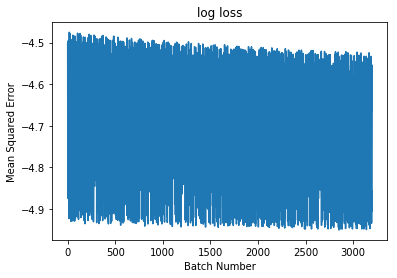

In [17]:
plt.plot(np.log10(history.losses))
plt.title('log loss')
plt.xlabel('Batch Number')
plt.ylabel('Mean Squared Error')
plt.show()

In [18]:
pred_test = model.predict(X_test)
to_show_ref_test = y_test
to_show_us_test = X_test

pred_train = model.predict(generator.x_ref)
to_show_ref_train  = generator.y_ref
to_show_us_train = generator.x_ref

#mean_squared_error = tf.keras.losses.mean_squared_error(pred_test, to_show_ref_test)
#print(mean_squared_error)

In [19]:
def show_images(slice_to_show, pred, ref, us):
    im1 = pred[slice_to_show, :, :, 0]    
    im2 = ref[slice_to_show, :, :, 0]
    im3 = dd.sos(us[slice_to_show, :, :, :], axis=2)

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack((im1, im2, im3)), cmap='gray')
    plt.title('pred | ref | us')
    plt.axis('off')
    plt.show()

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(abs(im2 - im1)* 10, cmap='gray', vmin=0, vmax=1)
    plt.title('diff x10')
    plt.axis('off')
    plt.show()

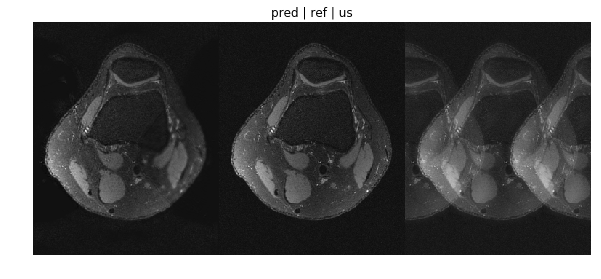

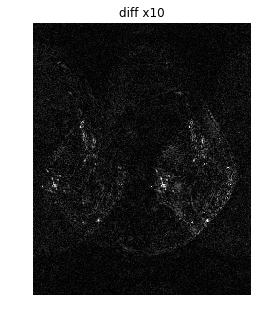

In [20]:
slice_to_show = 100
show_images(slice_to_show, pred_test, to_show_ref_test, to_show_us_test)

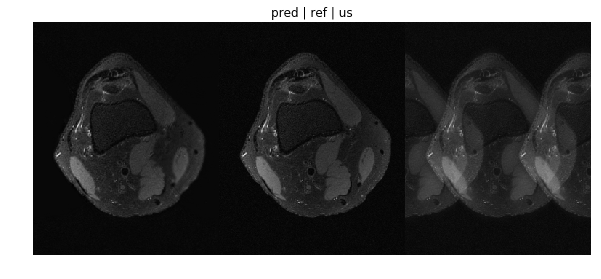

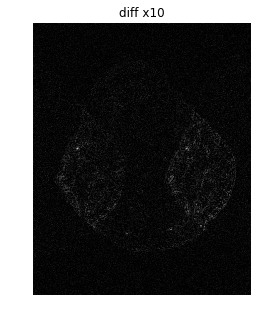

In [21]:
show_images(slice_to_show, pred_train, to_show_ref_train, to_show_us_train)

In [ ]:
#model.save('models/very_small_unet_no_aug_kernel_1_3_no_pooling.h5')